In [75]:
import cv2
import matplotlib.pyplot as plt

In [76]:
# Input image
image = cv2.imread('/adele.webp')

# Check if image is loaded correctly
if image is not None:
    image = cv2.resize(image, (720, 640))
else:
    print("Failed to load image. Check file path and ensure the image exists.")

In [77]:
# Importing Models and set mean values
face_model_txt = "/opencv_face_detector.pbtxt"
face_model_bin = "/opencv_face_detector_uint8.pb"
age_model_txt = "/age_deploy.prototxt"
age_model_bin = "/age_net.caffemodel"
gender_model_txt  = "/gender_deploy.prototxt"
gender_model_bin  = "/gender_net.caffemodel"

MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)

# Face
face_net = cv2.dnn.readNet(face_model_bin, face_model_txt)

# age
age_net = cv2.dnn.readNet(age_model_bin, age_model_txt)

# gender
gender_net = cv2.dnn.readNet(gender_model_bin, gender_model_txt)

In [78]:
age_labels = ['(0-2)', '(4-6)', '(8-12)', '(15-20)',
      '(25-32)', '(38-43)', '(48-53)', '(60-100)']
gender_labels = ['Male', 'Female']

In [79]:
# Copy image
fr_cv = image.copy()

In [80]:
# Face detection
fr_h = fr_cv.shape[0]
fr_w = fr_cv.shape[1]
blob = cv2.dnn.blobFromImage(fr_cv, 1.0, (300, 300),
                             [104, 117, 123], True, False)

face_net.setInput(blob)
detections = face_net.forward()


In [81]:
# Face bounding box creation
faceBoxes = []
for i in range(detections.shape[2]):

    #Bounding box creation if confidence > 0.7
    confidence = detections[0, 0, i, 2]
    if confidence > 0.7:

        x1 = int(detections[0, 0, i, 3]*fr_w)
        y1 = int(detections[0, 0, i, 4]*fr_h)
        x2 = int(detections[0, 0, i, 5]*fr_w)
        y2 = int(detections[0, 0, i, 6]*fr_h)

        faceBoxes.append([x1, y1, x2, y2])

        cv2.rectangle(fr_cv, (x1, y1), (x2, y2),
                      (0, 255, 0), int(round(fr_h/150)), 8)

faceBoxes


[[291, 83, 448, 395]]

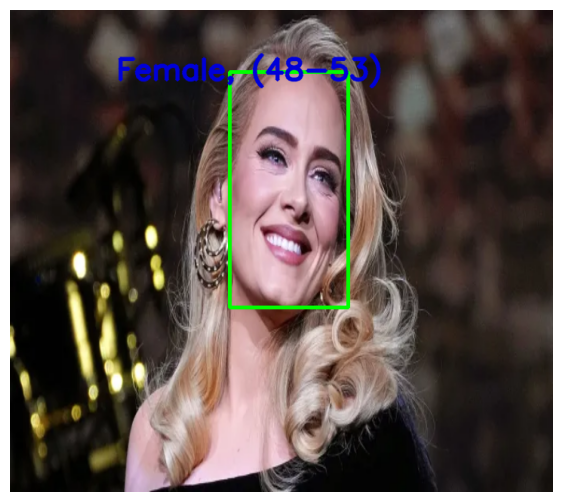

In [82]:
# Checking if face detected or not
if not faceBoxes:
    print("No face detected")

# else
# Loop for all the faces detected
for faceBox in faceBoxes:

    #Extracting face as per the faceBox
    face = fr_cv[max(0, faceBox[1]-15):
                 min(faceBox[3]+15, fr_cv.shape[0]-1),
                 max(0, faceBox[0]-15):min(faceBox[2]+15,
                               fr_cv.shape[1]-1)]

    #Extracting the main blob part
    blob = cv2.dnn.blobFromImage(
        face, 1.0, (227, 227), MODEL_MEAN_VALUES, swapRB=False)

    #Prediction of gender
    gender_net.setInput(blob)
    genderPreds = gender_net.forward()
    gender = gender_labels[genderPreds[0].argmax()]

    #Prediction of age
    age_net.setInput(blob)
    agePreds = age_net.forward()
    age = age_labels[agePreds[0].argmax()]

    #Putting text of gender
    #At the top of box
    cv2.putText(fr_cv,
                f'{gender}, {age}',
                (faceBox[0]-150, faceBox[1]+10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1.3,
                (217, 0, 0),
                4,
                cv2.LINE_AA)

    # Convert BGR to RGB for Matplotlib display
    fr_cv_rgb = cv2.cvtColor(fr_cv, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(7, 7))
    plt.imshow(fr_cv_rgb)
    plt.axis('off')
    plt.show()
